In [5]:
%matplotlib inline
from ecell4 import *
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import sys
import os
from ecell4.extra import ensemble

def wrap(job,job_id,task_id):
    def singlerun(duration,Ke,p3,conc2,run):
        import numpy as np
        from numpy import sqrt,log,pi
        gamma=0.5772157
        f=1.0208582        
        p2=p3
        #kr = 200*2
        kd = 10
        rm=0.005
        rv=rm*f
        l = 2*rv  
        L=rm*100*2
        h=L*2 #width of cuboid compartment
        Dc = 10.
        Dms = [10,10./3,1,1./3,0.1,1./30]
        Dm = Dms[run-1]     
        conc=600*5
        factor = (2 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0) + sqrt(22.0))**2/(72 * (6 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0)))
        h0=0 #lower vertex of cuboid
        h1=h #upper vertex of cuboid
        k3 = 3*np.sqrt(2)*Dc*l*p3
        k2a = 4*pi*Dm/(((2*pi/sqrt(3))*(1./p2-1))+2*gamma-log(f*f/12))   
        k2 = p2*Dm/factor 
        Ke2 = 0.001
        kr = k2a/Ke2#Ke2=k2a/kr
        ka = kd*Ke
        with species_attributes():
            Ac| {'radius':str(rv),'D': str(Dc)}
            Am| {'radius':str(rv),'D': str(Dm),"location":"M"}
            B| {'radius':str(rv),'D': str(0),"location":"M"}
            C| {'radius':str(rv),'D': str(Dm),"location":"M"}
        with reaction_rules():
            Ac + M > Am | ka
            Am > Ac | kd
            Ac + B > C | k3
            Am + B == C | (k2,kr)
        m = get_model()
        w = spatiocyte.SpatiocyteWorld(Real3(L,h,L),rv)
        lx,ly,lz=w.actual_lengths()
        Area=lx*lz
        V = Area*ly        
        NA = int(conc*V)
        NB = int(conc2*Area)
        assert(NB>0)        
        w.bind_to(m)
        size=tuple(w.calculate_shape(Real3(L,h,L),rv))
        Nmv=size[1]*size[2]            
        upper = Real3(0,h1-2*rv,0)
        lower = Real3(0,h0,0)
        unit0 = Real3(0,0,L)
        unit1 = Real3(L,0,0)
        w.add_structure(Species("M"),PlanarSurface(upper,unit0,unit1))
        w.add_structure(Species("W"),PlanarSurface(lower,unit0,unit1))
        w.add_molecules(Species("Ac"),NA)
        w.add_molecules(Species("B"),NB)
        print('run={},Dc={:.0f},Dm={:.2f}\n L={},h={},Area={:.2f},Vol={:.2f}\n NA={:.0f},NB={:.0f},Nsurface={}\n ka={:.2e},kd={:.2e},k2D={:.2e},k3D={:.2e},kr={:.2e}\n '.format(run,Dc,Dm,L,h,Area,V,NA,NB,Nmv,ka,kd,k2a,k3,kr))
        sim = spatiocyte.SpatiocyteSimulator(w)
        dt=50
        obs1 = FixedIntervalNumberObserver(duration/dt, ['C','B','Am','Ac'])
        sim.run(duration, obs1)   
        t,o1,o2,o3,o4=np.array(obs1.data()).T     
        return t,o1,o2,o3,o4,[Dc/Dm,ka/kd,NB,Area,V,p2,L,kr]
    job.update({'run':task_id})
    out=singlerun(**job)
    return out   


In [7]:
duration = 3
Ke =0.15#0.05#
run = 6

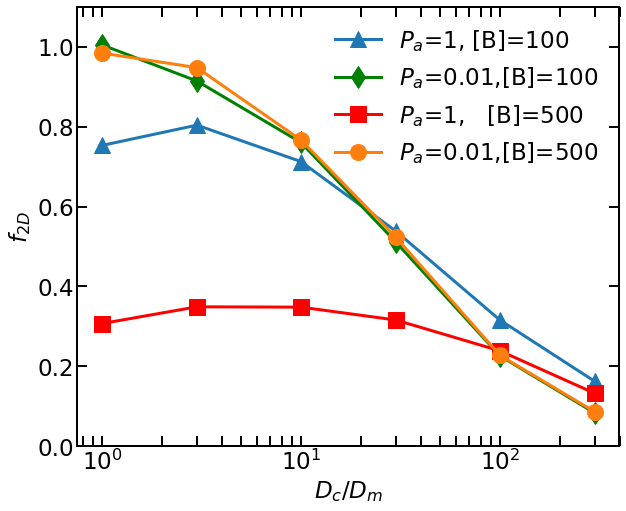

In [47]:
fig,ax=plt.subplots(1,1,figsize=(8.6,7))
fs=23
ms=16
lw=3

rD =[  1. , 3,10.,  30., 100. ,300.]
#rD = [1,10,100]
rDrange = np.logspace(0,3,20)
lss =['--','-','-.','dotted','']
ii=0

ax.semilogx(rD,p1c100[2],'-',marker='^',label='$P_a$=1, [B]=100',markersize = ms,linewidth=lw)
ax.semilogx(rD,p001c100[2],'g-d',label='$P_a$=0.01,[B]=100',markersize = ms,linewidth=lw)
ax.semilogx(rD,p1c500[2],'r-s',label='$P_a$=1,   [B]=500',markersize = ms,linewidth=lw)
ax.semilogx(rD,p001c500[2],'-o',label='$P_a$=0.01,[B]=500',markersize = ms,linewidth=lw)

ax.set_ylabel('$f_{2D}$',fontsize=fs)
ax.set_xlabel('$D_c/D_m$',fontsize=fs)
#ax.axhline(0.5,1e-2,10,linestyle='--')
ax.set_ylim(0,1.1)
ax.legend(fontsize=fs,loc='best',frameon=0)
ax.tick_params(labelsize=fs)    
fig.tight_layout(pad=0)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='both',which='both',direction='in',length=10,width=2)
